<a href="https://colab.research.google.com/github/Txlu-OG/AI-Project/blob/main/AI_Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3: Machine Learning for Predicting Trading Signals
Using cleaned data from Project 2 (cleaned_model_ready_dataset.csv)

Pipeline:
- Load cleaned model-ready data from Project 2
- Manually compute MACD and RSI (no external TA library)
- Define Buy / Sell / Hold signals based on MACD & RSI
- Build a feature matrix (technical indicators + existing features)
- Time-based train / test split
- Train Logistic Regression, Random Forest, SVM
- Evaluate models (accuracy, precision, recall, F1, confusion matrix)
- Save metrics and predictions for the report

In [6]:
# Imports and configuration

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from pathlib import Path
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import StratifiedKFold, cross_val_score

plt.style.use("default")

# ---- Config ----
DATA_PATH = Path("/content/drive/MyDrive/cleaned_model_ready_dataset.csv")
OUTPUT_DIR = Path("project3_outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

RANDOM_STATE = 42
TOP_N_TICKERS = 100
RSI_PERIOD = 14
MAX_ROWS_MODEL = 50_000      # hard cap on total rows for modeling

In [7]:

# Load cleaned data from Project 2

print("Loading cleaned dataset from Project 2...")
if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"{DATA_PATH} not found. Make sure Project 2 saved cleaned_model_ready_dataset.csv at this location."
    )

df = pd.read_csv(DATA_PATH, parse_dates=["date"])
df = df.set_index("date").sort_index()
print("Initial shape:", df.shape)
print(df.head())

if "ticker" not in df.columns:
    raise ValueError("Expected a 'ticker' column in cleaned_model_ready_dataset.csv.")

df.index = pd.to_datetime(df.index, errors="coerce")
df = df[df.index.notna()].sort_values(["ticker", df.index.name])

df["ticker"] = df["ticker"].astype("category")

# Drop heavy columns not needed for Project 3
drop_cols = [
    "close",
    "adj_close",
    "price_before_wins",
    "volume_before_wins",
    "target_return_next",
]
drop_cols = [c for c in drop_cols if c in df.columns]
if drop_cols:
    print("\nDropping unused columns:", drop_cols)
    df = df.drop(columns=drop_cols)

# Downcast numeric types to save memory
num_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
for col in num_cols:
    if col in ["year", "decade"]:
        df[col] = df[col].astype("int16")
    else:
        df[col] = df[col].astype("float32")

# Keep bool dummies as bool
bool_cols = df.select_dtypes(include=["bool"]).columns.tolist()
for col in bool_cols:
    df[col] = df[col].astype("bool")

print("\nDtypes after downcasting:")
df.info(memory_usage="deep")

# Restrict to top N tickers (by row count) for extra safety
if TOP_N_TICKERS is not None:
    counts = df["ticker"].value_counts()
    top_tickers = counts.head(TOP_N_TICKERS).index
    df = df[df["ticker"].isin(top_tickers)].copy()
    print(f"\nRestricted to top {TOP_N_TICKERS} tickers.")
    print("New shape:", df.shape)

Loading cleaned dataset from Project 2...
Initial shape: (1119063, 32)
           ticker      open      high       low     close    volume  \
date                                                                  
1970-01-06     AA -0.362560 -0.363234 -0.361919 -0.363982 -0.511712   
1970-01-06    MRO -0.395305 -0.396925 -0.397098 -0.398180 -0.494737   
1970-01-06    CAT -0.456533 -0.457420 -0.458591 -0.458896 -0.508393   
1970-01-06    CNP -0.251803 -0.255146 -0.255870 -0.256521 -0.531321   
1970-01-06    MRK -0.506307 -0.506283 -0.506491 -0.506194 -0.391042   

            adj_close  year  decade  price_before_wins  ...  \
date                                                    ...   
1970-01-06  -0.319748  1970    1970           1.949497  ...   
1970-01-06  -0.372242  1970    1970           0.201329  ...   
1970-01-06  -0.367229  1970    1970           0.368259  ...   
1970-01-06  -0.375057  1970    1970           0.107576  ...   
1970-01-06  -0.370217  1970    1970           0.26875

In [8]:

# Choose price column and ensure core numerics

price_col = None
for c in ["price_wins", "adj_close", "adjclose"]:
    if c in df.columns:
        price_col = c
        break
if price_col is None and "close" in df.columns:
    price_col = "close"
if price_col is None:
    raise ValueError(
        "No price column found among ['price_wins', 'adj_close', 'adjclose', 'close']."
    )

print(f"\nUsing '{price_col}' as primary price for MACD/RSI.")

core_numeric_cols = [
    price_col,
    "open", "high", "low", "volume",
    "return", "ma_7", "ma_30", "vol_30",
    "range_hl", "range_pct",
]
core_numeric_cols = [c for c in core_numeric_cols if c in df.columns]

for col in core_numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

if "return" not in df.columns:
    print("Column 'return' not found, computing daily return from price...")
    df["return"] = (
        df.groupby("ticker", observed=True)[price_col]
        .pct_change()
        .astype("float32")
    )

df = df.dropna(subset=[price_col, "volume", "open", "high", "low", "return"])
print("\nShape after dropping rows with missing core numerics:", df.shape)

before_dupes = df.shape[0]
df = df.reset_index().drop_duplicates().set_index("date")
after_dupes = df.shape[0]
print("Removed duplicate rows:", before_dupes - after_dupes)


Using 'price_wins' as primary price for MACD/RSI.

Shape after dropping rows with missing core numerics: (1119063, 27)
Removed duplicate rows: 0


In [9]:

# Manually compute MACD

print("\nComputing MACD...")

group_price = df.groupby("ticker", observed=True)[price_col]

df["ema12"] = group_price.transform(
    lambda x: x.ewm(span=12, adjust=False).mean()
).astype("float32")
df["ema26"] = group_price.transform(
    lambda x: x.ewm(span=26, adjust=False).mean()
).astype("float32")

df["macd"] = (df["ema12"] - df["ema26"]).astype("float32")

group_macd = df.groupby("ticker", observed=True)["macd"]
df["macd_signal"] = group_macd.transform(
    lambda x: x.ewm(span=9, adjust=False).mean()
).astype("float32")
df["macd_hist"] = (df["macd"] - df["macd_signal"]).astype("float32")


Computing MACD...


In [10]:

# Manually compute RSI

print("\nComputing RSI...")

df["delta"] = df.groupby("ticker", observed=True)[price_col].diff()
df["gain"] = df["delta"].clip(lower=0)
df["loss"] = -df["delta"].clip(upper=0)

alpha = 1.0 / RSI_PERIOD

df["avg_gain"] = (
    df.groupby("ticker", observed=True)["gain"]
    .transform(lambda x: x.ewm(alpha=alpha, adjust=False).mean())
)
df["avg_loss"] = (
    df.groupby("ticker", observed=True)["loss"]
    .transform(lambda x: x.ewm(alpha=alpha, adjust=False).mean())
)

rs = df["avg_gain"] / df["avg_loss"]
df["rsi"] = 100.0 - (100.0 / (1.0 + rs))
df.loc[df["avg_loss"] == 0, "rsi"] = 100.0
df["rsi"] = df["rsi"].astype("float32")

# Drop early indicator NaNs
indicator_cols = ["macd", "macd_signal", "macd_hist", "rsi"]
df = df.dropna(subset=indicator_cols).copy()
print("Shape after dropping early indicator NaNs:", df.shape)

# Drop intermediate columns we no longer need
drop_int_cols = ["ema12", "ema26", "delta", "gain", "loss", "avg_gain", "avg_loss"]
drop_int_cols = [c for c in drop_int_cols if c in df.columns]
df.drop(columns=drop_int_cols, inplace=True)
gc.collect()


Computing RSI...
Shape after dropping early indicator NaNs: (1118963, 38)


31

In [11]:

# Define Buy / Sell / Hold signals (no groupby.apply)

print("\nDefining Buy / Sell / Hold signals...")

macd_prev = df.groupby("ticker", observed=True)["macd"].shift(1)
sig_prev = df.groupby("ticker", observed=True)["macd_signal"].shift(1)

df["macd_buy"] = ((df["macd"] > df["macd_signal"]) & (macd_prev <= sig_prev)).astype("int8")
df["macd_sell"] = ((df["macd"] < df["macd_signal"]) & (macd_prev >= sig_prev)).astype("int8")

df["rsi_buy"] = (df["rsi"] < 30).astype("int8")
df["rsi_sell"] = (df["rsi"] > 70).astype("int8")

signal = np.zeros(len(df), dtype="int8")
buy_mask = (df["macd_buy"] == 1) & (df["rsi_buy"] == 1)
sell_mask = (df["macd_sell"] == 1) & (df["rsi_sell"] == 1)
signal[buy_mask.values] = 1
signal[sell_mask.values] = -1
df["signal_label"] = signal

print("Signal distribution (before subsampling):")
print(df["signal_label"].value_counts())


Defining Buy / Sell / Hold signals...
Signal distribution (before subsampling):
signal_label
 0    1117756
-1        846
 1        361
Name: count, dtype: int64



Building modeling DataFrame and subsampling...
df_model shape before subsampling: (1118963, 32)
Buy+Sell rows: 1207, Hold rows: 1117756
df_model_small shape after subsampling: (50000, 32)
New signal distribution:
signal_label
 0    48793
-1      846
 1      361
Name: count, dtype: int64


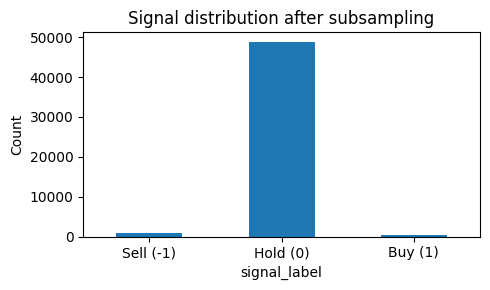

In [12]:

# Build a modeling DataFrame and subsample to MAX_ROWS_MODEL

print("\nBuilding modeling DataFrame and subsampling...")

# Sector dummies from Project 2
sector_dummy_cols = [c for c in df.columns if c.startswith("sector_")]

feature_base_cols = [
    "price_wins",
    "open", "high", "low", "volume",
    "return",
    "volume_wins",
    "ma_7", "ma_30", "vol_30",
    "range_hl", "range_pct",
    "macd", "macd_signal", "macd_hist", "rsi",
]

feature_base_cols = [c for c in feature_base_cols if c in df.columns]
feature_base_cols = list(dict.fromkeys(feature_base_cols))

time_feature_cols = [c for c in ["year", "decade"] if c in df.columns]

feature_cols = feature_base_cols + sector_dummy_cols + time_feature_cols

# Make a compact modeling DataFrame
df_model = df[feature_cols + ["signal_label", "ticker"]].dropna().copy()
df_model = df_model.sort_index()
print("df_model shape before subsampling:", df_model.shape)

# Separate Buy/Sell vs Hold
buy_sell_df = df_model[df_model["signal_label"] != 0]
hold_df = df_model[df_model["signal_label"] == 0]

n_buy_sell = len(buy_sell_df)
n_hold = len(hold_df)

print(f"Buy+Sell rows: {n_buy_sell}, Hold rows: {n_hold}")

if n_buy_sell == 0:
    raise ValueError("No Buy/Sell signals found. Cannot train classifier.")

remaining_capacity = MAX_ROWS_MODEL - n_buy_sell
if remaining_capacity <= 0:
    print(f"MAX_ROWS_MODEL={MAX_ROWS_MODEL} is smaller than Buy+Sell rows; using only Buy+Sell.")
    df_model_small = buy_sell_df.copy()
else:
    n_hold_keep = min(n_hold, remaining_capacity)
    hold_sample = hold_df.sample(
        n=n_hold_keep,
        random_state=RANDOM_STATE,
        replace=False,
    )
    df_model_small = pd.concat([buy_sell_df, hold_sample], axis=0).sort_index()

print("df_model_small shape after subsampling:", df_model_small.shape)
print("New signal distribution:")
print(df_model_small["signal_label"].value_counts())

# Simple bar plot of signal distribution
plt.figure(figsize=(5, 3))
df_model_small["signal_label"].value_counts().sort_index().plot(
    kind="bar"
)
plt.xticks(
    ticks=[0, 1, 2],
    labels=["Sell (-1)", "Hold (0)", "Buy (1)"],
    rotation=0,
)
plt.ylabel("Count")
plt.title("Signal distribution after subsampling")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "signal_distribution_after_subsampling.png", bbox_inches="tight")
plt.show()

In [13]:
# Final feature matrix and time split

print("\nPreparing feature matrix and time-based train/test split...")

X_all = df_model_small[feature_cols]
y_all = df_model_small["signal_label"]

# Time split directly on df_model_small to avoid mask length issues
cutoff_test = "2012-12-31"

train_df = df_model_small.loc[df_model_small.index <= cutoff_test]
test_df = df_model_small.loc[df_model_small.index > cutoff_test]

X_train = train_df[feature_cols].copy()
y_train = train_df["signal_label"].copy()

X_test = test_df[feature_cols].copy()
y_test = test_df["signal_label"].copy()

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train label distribution:")
print(y_train.value_counts())
print("Test label distribution:")
print(y_test.value_counts())



Preparing feature matrix and time-based train/test split...
Train shape: (43611, 30) Test shape: (6389, 30)
Train label distribution:
signal_label
 0    42610
-1      674
 1      327
Name: count, dtype: int64
Test label distribution:
signal_label
 0    6183
-1     172
 1      34
Name: count, dtype: int64


In [14]:
# Standardize numeric features


print("\nStandardizing numeric features...")

numeric_features = [c for c in feature_cols if not c.startswith("sector_")]

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

print("Standardization complete.")


Standardizing numeric features...
Standardization complete.


In [15]:
# Train models

print("\nTraining models...")

models = {}

# 1. Logistic Regression
log_reg = LogisticRegression(
    max_iter=500,
    multi_class="multinomial",
    n_jobs=-1,
    random_state=RANDOM_STATE,
)
log_reg.fit(X_train_scaled, y_train)
models["LogisticRegression"] = log_reg
print("Trained Logistic Regression.")

# 2. Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight="balanced_subsample",
)
rf.fit(X_train_scaled, y_train)
models["RandomForest"] = rf
print("Trained Random Forest.")

# 3. SVM (data already small enough)
svm_clf = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",
    random_state=RANDOM_STATE,
)
svm_clf.fit(X_train_scaled, y_train)
models["SVM"] = svm_clf
print("Trained SVM.")


Training models...
Trained Logistic Regression.
Trained Random Forest.
Trained SVM.



Evaluating models on test set...

=== LogisticRegression ===
Accuracy: 0.9693222726561277
Precision (macro): 0.7359666403992645
Recall (macro): 0.42407210863613426
F1 (macro): 0.4779962481111906

Classification report:
              precision    recall  f1-score   support

          -1     0.6111    0.1279    0.2115       172
           0     0.9718    0.9973    0.9844      6183
           1     0.6250    0.1471    0.2381        34

    accuracy                         0.9693      6389
   macro avg     0.7360    0.4241    0.4780      6389
weighted avg     0.9602    0.9693    0.9596      6389

Confusion matrix (rows=true, cols=pred):
[[  22  150    0]
 [  14 6166    3]
 [   0   29    5]]


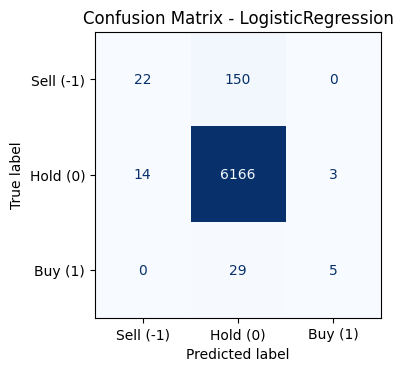


=== RandomForest ===
Accuracy: 0.992330568164032
Precision (macro): 0.9682632596351336
Recall (macro): 0.7542673787673261
F1 (macro): 0.8035487122428897

Classification report:
              precision    recall  f1-score   support

          -1     0.9101    0.9419    0.9257       172
           0     0.9947    0.9974    0.9960      6183
           1     1.0000    0.3235    0.4889        34

    accuracy                         0.9923      6389
   macro avg     0.9683    0.7543    0.8035      6389
weighted avg     0.9924    0.9923    0.9915      6389

Confusion matrix (rows=true, cols=pred):
[[ 162   10    0]
 [  16 6167    0]
 [   0   23   11]]


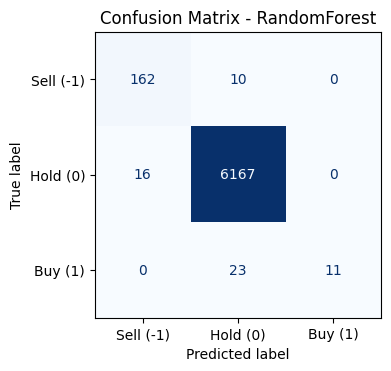


=== SVM ===
Accuracy: 0.967757082485522
Precision (macro): 0.48930118469808465
Recall (macro): 0.33521740656739474
F1 (macro): 0.3317020089795993

Classification report:
              precision    recall  f1-score   support

          -1     0.5000    0.0058    0.0115       172
           0     0.9679    0.9998    0.9836      6183
           1     0.0000    0.0000    0.0000        34

    accuracy                         0.9678      6389
   macro avg     0.4893    0.3352    0.3317      6389
weighted avg     0.9502    0.9678    0.9522      6389

Confusion matrix (rows=true, cols=pred):
[[   1  171    0]
 [   1 6182    0]
 [   0   34    0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


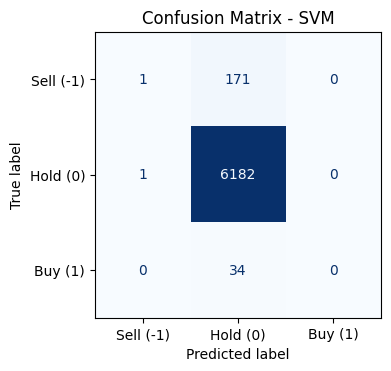


Summary metrics:
                model  accuracy  precision_macro  recall_macro  f1_macro
0  LogisticRegression  0.969322         0.735967      0.424072  0.477996
1        RandomForest  0.992331         0.968263      0.754267  0.803549
2                 SVM  0.967757         0.489301      0.335217  0.331702


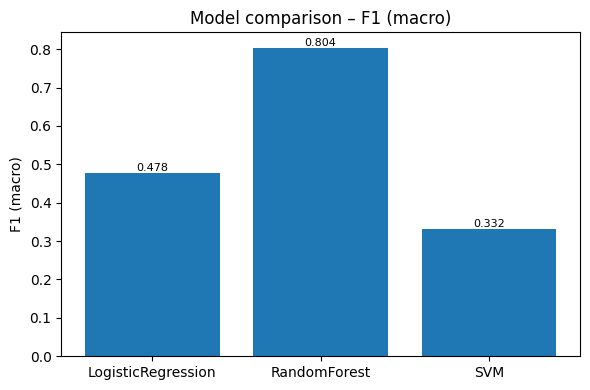

In [16]:
# Evaluation on test set (with visualizations)

print("\nEvaluating models on test set...")

metrics_rows = []

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)

    # Basic metrics
    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="macro", zero_division=0
    )

    metrics_rows.append({
        "model": name,
        "accuracy": acc,
        "precision_macro": precision,
        "recall_macro": recall,
        "f1_macro": f1,
    })

    print(f"\n=== {name} ===")
    print("Accuracy:", acc)
    print("Precision (macro):", precision)
    print("Recall (macro):", recall)
    print("F1 (macro):", f1)
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, digits=4))
    print("Confusion matrix (rows=true, cols=pred):")

    # Confusion matrix (numeric)
    cm = confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])
    print(cm)

    # Confusion matrix heatmap
    fig, ax = plt.subplots(figsize=(4, 4))
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Sell (-1)", "Hold (0)", "Buy (1)"],
    )
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f"confusion_matrix_{name}.png", bbox_inches="tight")
    plt.show()

metrics_df = pd.DataFrame(metrics_rows)
print("\nSummary metrics:")
print(metrics_df)

# Simple bar plot of model F1 scores
plt.figure(figsize=(6, 4))
plt.bar(metrics_df["model"], metrics_df["f1_macro"])
plt.ylabel("F1 (macro)")
plt.title("Model comparison – F1 (macro)")
for i, v in enumerate(metrics_df["f1_macro"]):
    plt.text(i, v, f"{v:.3f}", ha="center", va="bottom", fontsize=8)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "model_f1_macro_comparison.png", bbox_inches="tight")
plt.show()

In [17]:
# Simple cross-validation for Logistic Regression

print("\nRunning simple 3-fold CV (F1_macro) on Logistic Regression (train set)...")

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(
    log_reg, X_train_scaled, y_train, cv=skf, scoring="f1_macro"
)

print("CV F1_macro scores:", cv_scores)
print("CV F1_macro mean:", cv_scores.mean())


Running simple 3-fold CV (F1_macro) on Logistic Regression (train set)...
CV F1_macro scores: [0.4344186  0.43686493 0.43388156]
CV F1_macro mean: 0.43505502830544523


In [18]:
# Save outputs

print("\nSaving metrics and predictions...")

# Save summary metrics
metrics_df.to_csv(OUTPUT_DIR / "model_metrics_summary.csv", index=False)

# Build a single DataFrame with true labels and predictions for each model
preds_merged = pd.DataFrame(
    {
        "ticker": test_df["ticker"].astype(str).values,
        "true_signal": y_test.values,
    },
    index=X_test_scaled.index,
)

for name, model in models.items():
    preds_merged[f"pred_{name}"] = model.predict(X_test_scaled)

preds_merged.to_csv(OUTPUT_DIR / "test_predictions_all_models.csv")

print("Saved model_metrics_summary.csv and test_predictions_all_models.csv to:", OUTPUT_DIR.resolve())
print("\nProject 3 modeling complete.")


Saving metrics and predictions...
Saved model_metrics_summary.csv and test_predictions_all_models.csv to: /content/project3_outputs

Project 3 modeling complete.
